In [9]:
import requests
import time
import PySpin
import pyrealsense2 as rs
import sys
sys.path.append('../')
import capture_thermal_image as thermalcapture

ModuleNotFoundError: No module named 'PySpin'

In [8]:
!pip install PySpin --no-deps

In [ ]:
print(requests.get("http://localhost:8010/RestPLCService/getint?address=4020").json()["Value"])

In [ ]:
requests.get("http://localhost:8010/RestPLCService/setint?address=4010&value=%d" % 1209)

In [ ]:
requests.get("http://localhost:8010/RestPLCService/setint?address=4010&value=%d" % 1510)

In [ ]:
import time
import pyrealsense2 as rs
import numpy as np
import cv2
from datetime import datetime
import os
import json

In [ ]:
"""
Author: spsaswat & Zishuang Xing

Description:
This script demonstrates the process of acquiring images using the Intel RealSense camera via the pyrealsense2 library. 
The script showcases essential steps including starting and stopping the camera pipeline, capturing a specified number 
of images with a delay between each capture, saving camera intrinsics, and handling file paths dynamically based on the 
execution time. This utility is particularly useful in computer vision applications that require synchronized color and 
depth data from RealSense cameras.

"""

# Initialize the global variable
current_position = 0.0
all_imgs = []

# serial_number = 'f1230450' #L515
# serial_number = '017322071325' #D435
serial_number = '128422272123'  #D405

#Set the basic path for data storage
save_fold_p = './data/test_plant_'

now = datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")
save_fold_p = save_fold_p + dt_string + '/'
#If it does not exist, create a save directory
os.makedirs(save_fold_p, exist_ok=True) 

def start_pipeline():
    # Start streaming
    pipeline.start(config)
    # Get the depth sensor and set the visual preset


def stop_pipeline():
    # Stop streaming
    pipeline.stop()
    

def save_intrinsics():
    # Get the intrinsics
    profile = pipeline.get_active_profile()
    
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()
    depth_sensor.set_option(rs.option.visual_preset, 4)  # 4 High accuracy for D435 and D405 # 5 L515 short range 

    # depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.color))  #change it back if it doesnot work
    depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.depth))
    depth_intrinsics = depth_profile.get_intrinsics()

    # Save the intrinsics in the required format
    intrinsics_dict = {
        "K": [
            [depth_intrinsics.fx, 0, depth_intrinsics.ppx],
            [0, depth_intrinsics.fy, depth_intrinsics.ppy],
            [0, 0, 1]
        ],
        # Assuming that the distortion model is "Brown-Conrady",
        # you can get the distortion parameters like this.
        "dist": depth_intrinsics.coeffs,
        "height": depth_intrinsics.height,
        "width": depth_intrinsics.width
    }

    # Write the data to a .txt file
    with open(save_fold_p+'kd_intrinsics.txt', 'w') as outfile:
        json.dump(intrinsics_dict, outfile, indent=4)
        
        
    #remove below code after intrinsics finalized
    depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.color)) 
    depth_intrinsics = depth_profile.get_intrinsics()

    # Save the intrinsics in the required format
    intrinsics_dict = {
        "K": [
            [depth_intrinsics.fx, 0, depth_intrinsics.ppx],
            [0, depth_intrinsics.fy, depth_intrinsics.ppy],
            [0, 0, 1]
        ],
        # Assuming that the distortion model is "Brown-Conrady",
        # you can get the distortion parameters like this.
        "dist": depth_intrinsics.coeffs,
        "height": depth_intrinsics.height,
        "width": depth_intrinsics.width
    }

    # Write the data to a .txt file
    with open(save_fold_p+'kdc_intrinsics.txt', 'w') as outfile:
        json.dump(intrinsics_dict, outfile, indent=4)


def capture_images(pipeline, position_str, total_images=1, delay=0):
    # Capture a specified number of images, pausing for a set time between captures
    for i in range(total_images):
        frames = pipeline.wait_for_frames()
        # Align depth frames to color frames to ensure depth and color data match
        aligned_frames = align.process(frames)
        depth_frame = aligned_frames.get_depth_frame()
        color_frame = aligned_frames.get_color_frame()
        
        # Convert frame data to numpy arrays for processing and saving with OpenCV
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        
        # # Save color and depth images with filenames "rgb_x.png" and "depth_x.png", where x is the sequence number
        # position_str = f"position_str" 
        
        cv2.imwrite(os.path.join(save_fold_p, f'rgb_{position_str}.png'), color_image)
        cv2.imwrite(os.path.join(save_fold_p, f'depth_{position_str}.png'), depth_image)

        time.sleep(delay) # Wait for a specified time (in seconds) between captures

# Configure the RealSense camera
pipeline = rs.pipeline()
config = rs.config()
config.enable_device(serial_number)
# Configure the stream parameters according to device capabilities and needs
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)  
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30) 
align = rs.align(rs.stream.color) #Align depth frames to color frames

# Sequentially execute starting the pipeline, saving intrinsics, capturing images, and stopping the pipeline
start_pipeline()
save_intrinsics()

In [ ]:
tt = requests.get("http://localhost:8010/RestPLCService/getint?address=4020").json()["Value"]
print(str(tt))

In [ ]:
li_th_pos = [1340, 1055, 740, 435, 1510]
if requests.get("http://localhost:8010/RestPLCService/getint?address=4020").json()["Value"] != 1510:
    requests.get("http://localhost:8010/RestPLCService/setint?address=4010&value=%d" % 1510)
    time.sleep(10)
    print("The gantry's position is:", requests.get("http://localhost:8010/RestPLCService/getint?address=4020").json()["Value"])
    # call rgbd and thermal capture
    
for pos in li_th_pos:
    requests.get("http://localhost:8010/RestPLCService/setint?address=4010&value=%d" % pos)
    position_f = requests.get("http://localhost:8010/RestPLCService/getint?address=4020").json()["Value"]
    print("The gantry's position is:", position_f)
    time.sleep(10)
    # call rgbd and thermal capture
    capture_images(pipeline, position_f, 1, 0)

    # main start
    thermalcapture.NUM_IMAGES = 1
    thermalcapture.pos = position_f
    thermalcapture.main()
    # main end
    time.sleep(5)
   
    
stop_pipeline()

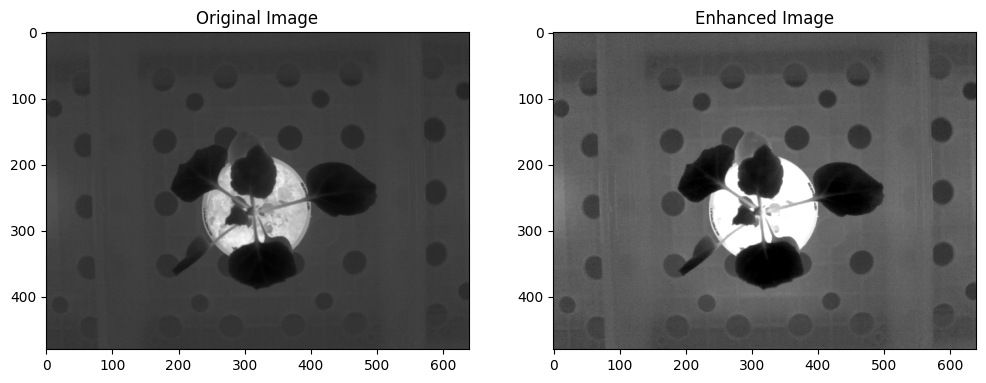

Original image range: 12830 to 14613
Enhanced image range: 0 to 65535


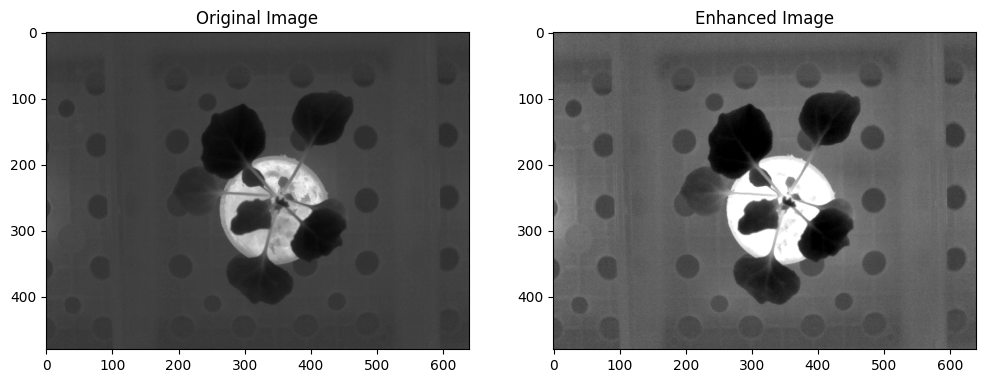

Original image range: 12833 to 14534
Enhanced image range: 0 to 65535


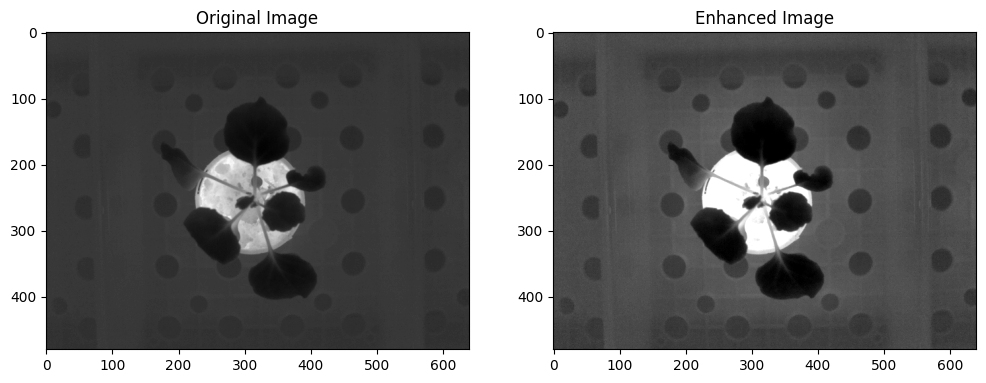

Original image range: 12806 to 14828
Enhanced image range: 0 to 65535


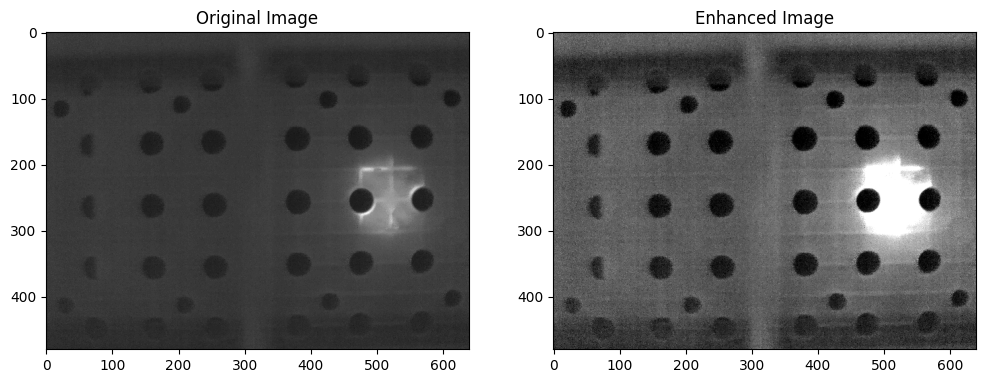

Original image range: 13085 to 13969
Enhanced image range: 0 to 65535


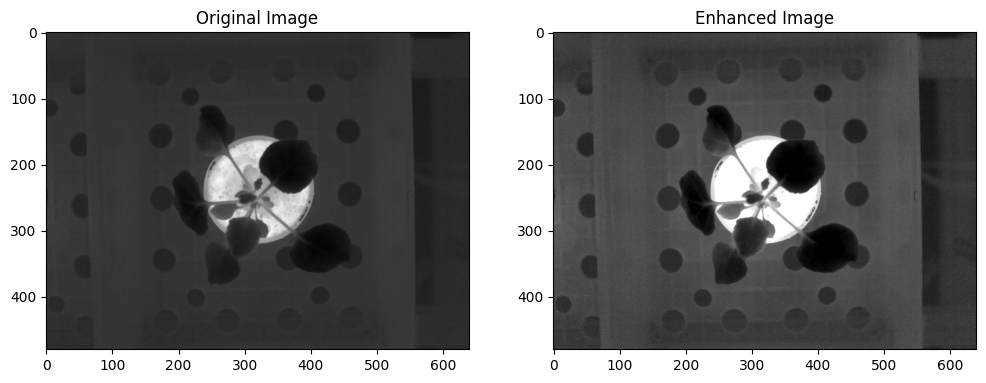

Original image range: 12898 to 14750
Enhanced image range: 0 to 65535


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def normalize_16bit(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def apply_clahe_16bit(image, clip_limit=4.0):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    return clahe.apply(image)

def stretch_contrast(image, low_percent=2, high_percent=98):
    low_val = np.percentile(image, low_percent)
    high_val = np.percentile(image, high_percent)
    return np.clip((image - low_val) / (high_val - low_val), 0, 1)

def process_image(image_path):
    # Load the image in 16-bit
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    # Normalize to [0, 1]
    normalized = normalize_16bit(image)
    
    # Convert back to 16-bit for CLAHE
    image_16bit = (normalized * 65535).astype(np.uint16)
    
    # Apply CLAHE with higher clip limit
    clahe_image = apply_clahe_16bit(image_16bit, clip_limit=6.0)
    
    # Normalize again after CLAHE
    normalized_clahe = normalize_16bit(clahe_image)
    
    # Apply contrast stretching
    stretched = stretch_contrast(normalized_clahe, low_percent=1, high_percent=99)
    
    # Final contrast adjustment
    final_image = np.clip(stretched * 1.3, 0, 1)  # Increase contrast more aggressively
    
    return (final_image * 65535).astype(np.uint16)  # Convert back to 16-bit format

def plot_images(original_image, enhanced_image):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_image, cmap='gray')
    plt.title('Enhanced Image')
    plt.show()

# Directory paths
# input_directory = "../SensorCommunication/Acquisition/20240815-155900_tiff/20240815-155900/"
# output_directory = "../SensorCommunication/Acquisition/20240815-155900_tiff/20240815-155900-calibrated/"
# input_directory = "../SensorCommunication/Acquisition/calib_data_2/calib_data_2/20240822-125442/"
# output_directory = "../SensorCommunication/Acquisition/calib_data_2/calib_data_2/20240822-125442/20240822-125442-calibrated/"
# input_directory = "../SensorCommunication/Acquisition/calib_data_3/20240823-144851/"
# output_directory = "../SensorCommunication/Acquisition/calib_data_3/20240823-144851-calibrated/"
input_directory = "../SensorCommunication/Acquisition/batch_1/20240903-103500/"
output_directory = "../SensorCommunication/Acquisition/batch_1/20240903-103500-calibrated/"

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Process each image in the directory
for filename in os.listdir(input_directory):
    if filename.endswith(".tiff"):
        input_path = os.path.join(input_directory, filename)
        output_path = os.path.join(output_directory, filename)
        
        # Load the original image
        original_image = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
        
        # Process the image
        enhanced_image = process_image(input_path)
        
        # Save the enhanced image
        cv2.imwrite(output_path, enhanced_image)
        
        # Plot the original and enhanced images
        plot_images(original_image, enhanced_image)

        # Debug: Print min and max values
        print(f"Original image range: {np.min(original_image)} to {np.max(original_image)}")
        print(f"Enhanced image range: {np.min(enhanced_image)} to {np.max(enhanced_image)}")